In [1]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import torch
import math
import matplotlib.pyplot as plt
import einops as E
import random
import sys
from collections import defaultdict
import torch.nn.functional as F

sys.path.append('/home/t722s/Desktop/UniversalModels/OtherRepos/UniverSeg')
from universeg import universeg

In [2]:
def read_volume(volume_path, fg_label = None, sizeXY = (128,128)):
    '''
    Given a path to a nifti volume, read it in, discarding everything but specified fg_label and resizing. Returns as a numpy array
    '''
    volume = nib.load(volume_path).get_fdata()
    if fg_label: # If is a label, set all other entries to 0. Mostly useful for multisegmentation datasets. 
        volume = np.where(volume == fg_label, volume, 0) # same as volume[volume!=fg_label] = 0, but faster. Could be even faster to use gpu, but I'm not sure about the switching back and forth.

    return(volume)

def _classify_list(l, delta = 3):
    '''
    Given a list of 1s and 0s (ie slices with foreground, slices with no foreground within a volume), return list of equal length classifying each element as 'bg', 'bgb', 'fgb' and 'fg', meaning background, background border, foreground border
    and foreground, with 'background border' meaning a 0 within delta of a 1, and similarly for 'foreground border'
    '''

    n = len(l)
    classification = [''] * n

    for i in range(n):
        # Check if within delta indices, there's an element of the other type
        lower = max(i-delta, 0)
        upper = min(i+delta+1, n)
        
        is_border = any(l[j] != l[i] 
                        for j in range(lower, upper))

        if l[i] == 1:
            classification[i] = 'fgb' if is_border else 'fg'
        else:
            classification[i] = 'bgb' if is_border else 'bg'

    return classification  

def get_support_inds(label, num_of_slices = [1,1,1,1]): 
    '''
    Given a label volume, gets uniformly sampled slices for each class (background, background-border, foreground-border, foreground) to use as indices for support slices. The number per class is defind by
    num_of_slices, representing the desired number of support slices from background, background border, foreground border and foreground respectively. Returns a list of slices
    '''
    fg_present = np.any(label!=0, axis = (0,1)) # Find slices containing foreground

    fg_present_nuanced = _classify_list(fg_present)

    support_inds = []

    for i, cls in enumerate(['bg', 'bgb', 'fgb', 'fg']):
        n = num_of_slices[i]

        # Sample n indices uniformly at random of type cls from l 
        cls_inds = [i for i, x in enumerate(fg_present_nuanced)  if x == cls] # ie the slice indices of type cls

        if n > fg_present_nuanced.count(cls):
            raise RuntimeError(f'Not enough slices of type {cls}')
        
        sampled_inds = random.sample(cls_inds, n)

        support_inds.extend(sampled_inds)

    return(support_inds)

def get_support_slices_and_labels(support_volume_paths, support_label_paths, fg_label, num_of_slices = [1,1,1,1], sizeXY = [128,128], device = 'cuda'):# Include infer label option for binary tasks
    '''
    Given support volumes and labels paths, extracts slices to use as 2D support sets. The number of slices extracted per volume is given by num_of_slices, which also determines where the slices are taken from within the volume.
    The paths in support_volume_paths and support_label_paths must correspond. Returns (support_slices, support_labels).
    '''

    if len(support_volume_paths) != len(support_label_paths):
        raise RuntimeError(f'Unequal number of support volume paths and labels given, {len(support_volume_paths)}, {len(support_label_paths)} respectively')

    support_slices = []
    support_labels = []


    # Obtain support slices and their labels
    for i in range(len(support_volume_paths)):
        # Load in volumes and labels as tuples of tensors
        volume = read_volume(support_volume_paths[i])
        label = read_volume(support_label_paths[i], fg_label = fg_label)

        # Choose indices to use to select support slices and labels
        support_inds = get_support_inds(label, num_of_slices)

        # obtain support slices and labels from support volumes and labels as torch tensors. Reorient the dimensions since z isn't spatial anymore, but just indexing chosen slices (necessary for F.interpolate)
        slices = torch.from_numpy(E.rearrange(volume[:, :, support_inds], 'x y z -> z x y')).unsqueeze(1)
        labels = torch.from_numpy(E.rearrange(label[:, :, support_inds], 'x y z -> z x y')).unsqueeze(1)

        # rescale here instead of after concatenation (ie so F.interpolate would only be called once) to allow for datasets with multiple volume dimensionalities, eg amos
        if sizeXY:
            # Minimum value will be kept, but maximum not
            imgMin = torch.min(slices)

            slices = F.interpolate(slices,
                                    size = sizeXY,
                                    mode = 'bicubic') # NOTE: unsure if I should use align_corners.
            
            slices = torch.clamp(slices, imgMin, float('inf'))

            labels = F.interpolate(labels,
                                    size = sizeXY,
                                    mode = 'nearest')

        support_slices.append(slices)
        support_labels.append(labels)

    support_slices = torch.from_numpy(np.concatenate(support_slices, axis = 0)).float() #.unsqueeze(0) not sure why I thoguht I needed this. Universeg? #concat along axis 0 and add explicit unidimensional color channel 
    support_labels = torch.from_numpy(np.concatenate(support_labels, axis = 0)).float()  #.unsqueeze(0)

    return (support_slices, support_labels)

def get_query_slices_and_labels(volume_path, label_path, fg_label):# Include infer label option for binary tasks
    '''
    Given support volumes and labels paths, extracts slices to use as 2D support sets. The number of slices extracted per volume in the case support = True is given by num_of_slices, which also determines where the slices are taken from within the volume.
    The paths in volume_paths and label_paths must correspond. Returns (support_slices, support_labels).
    '''
    volume = read_volume(volume_path)
    label = read_volume(label_path, fg_label = fg_label)

    # Reformat for rescaling and universeg
    slices = torch.from_numpy(E.rearrange(volume, 'x y z -> z x y')).unsqueeze(1)
    labels = torch.from_numpy(E.rearrange(label, 'x y z -> z x y')).unsqueeze(1)

    return (slices.float(), labels.float())


def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

@torch.no_grad()
def inference(model, image, label, support_images, support_labels, device = 'cuda'):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image,
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits        

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray', aspect = 'equal')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()



In [3]:
# MAIN SCRIPT
# Configurable parameters 
device = 'cuda'
sizeXY = [256,256]

# Obtain support slices
volume_dir = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTr/'
volume_paths = sorted([os.path.join(volume_dir, file) for file in os.listdir(volume_dir)]) # in later usage, if a random selection is desired, don't use sorted here, and use np.random.permutation later

label_dir = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/'
label_paths = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir)])
# Split volumes, labels into support and query sets
# volume_paths, label_paths = np.random.permutation(volume_paths), np.random.permutation(label_paths)
n_support_volumes = 6 # There for num_of_slices = [a,b,c,d], there'll be n_support_volumes * (a+b+c+d) total support slices
support_volume_paths,   query_volume_paths  = volume_paths[:n_support_volumes], volume_paths[n_support_volumes:]
support_label_paths,    query_label_paths   = label_paths[:n_support_volumes],  label_paths[n_support_volumes:] 

support_slices, support_labels = get_support_slices_and_labels(support_volume_paths, support_label_paths, fg_label = 1, num_of_slices= [0,0,1,1], sizeXY = sizeXY)
support_slices, support_labels = support_slices.to(device), support_labels.to(device)

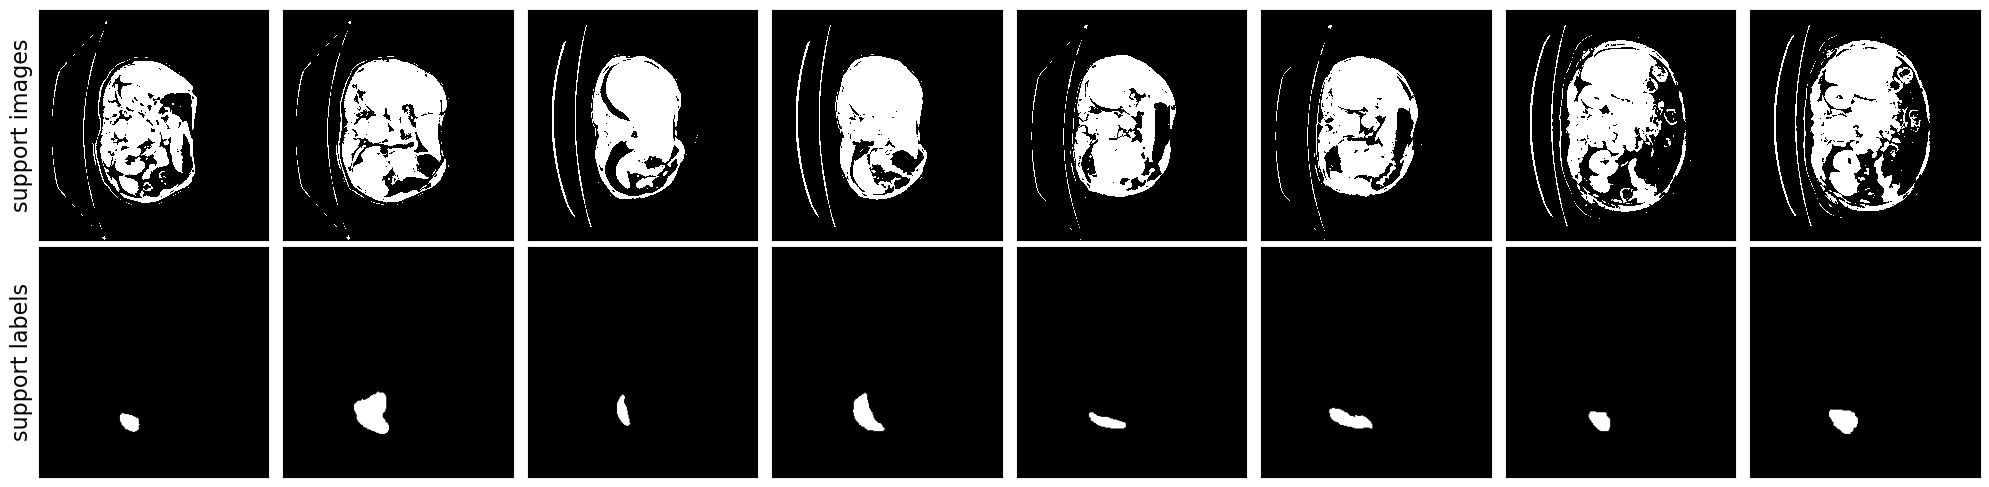

In [4]:
n_viz = 8
start = 0
visualize_tensors({
    'support images': support_slices[start: start+n_viz],
    'support labels': support_labels[start: start+n_viz]
})

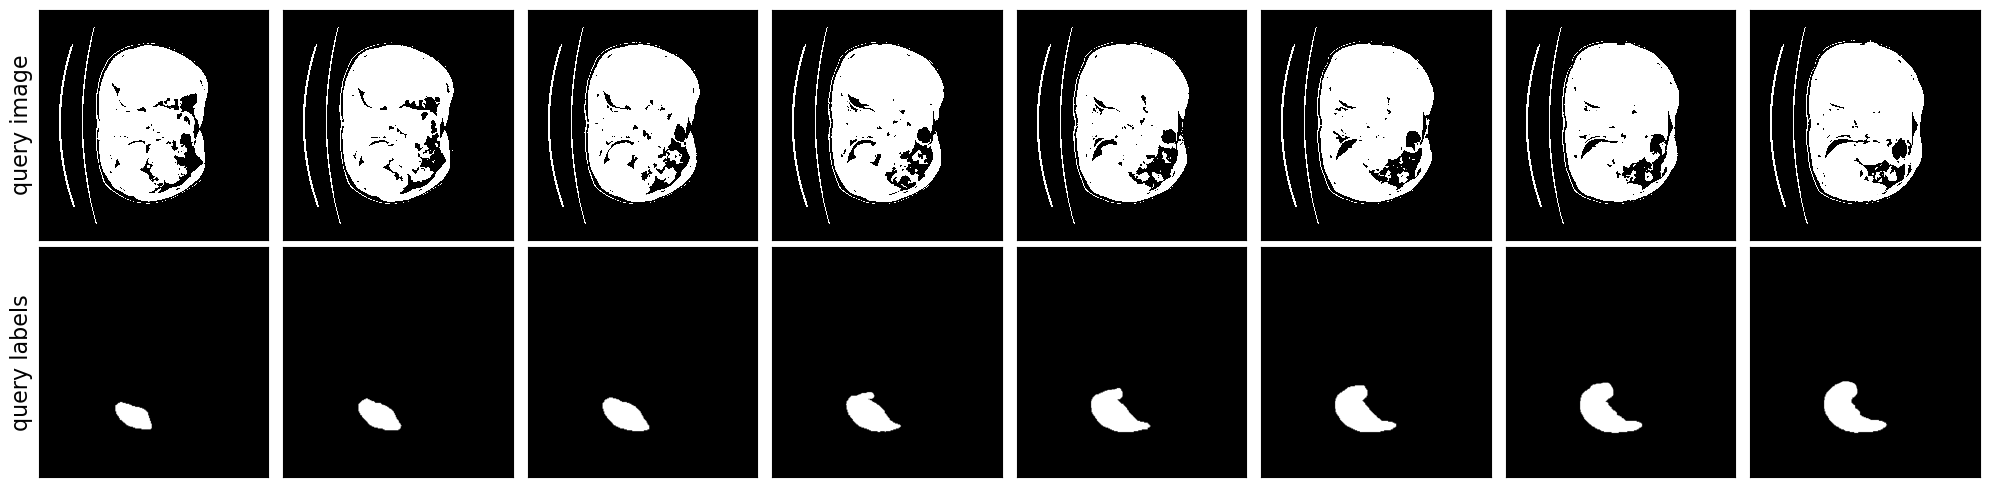

In [5]:
query_slices, query_labels = get_query_slices_and_labels(query_volume_paths[0], query_label_paths[0], 1)

n_viz = 8
start = 30

visualize_tensors({
    'query image': query_slices[start: start+n_viz],
    'query labels': query_labels[start: start+n_viz]
})


In [11]:
# Inference
model = universeg(pretrained=True)
_ = model.to(device)

# select an image, label test pair
idx = 30
image, label = query_slices[idx], query_labels[idx]
image, label = image.to(device), label.to(device)

# Since working with just one channel, need to explicity add a dimension for number of images for resizing.
image = image.unsqueeze(0)


# run inference
# resize query image
imgMin = torch.min(image)

image = F.interpolate(image,
                        size = sizeXY,
                        mode = 'bicubic') # NOTE: unsure if I should use align_corners.

label = F.interpolate(image,
                        size = sizeXY,
                        mode = 'nearest') # NOTE: unsure if I should use align_corners.


image = torch.clamp(image, imgMin, float('inf'))


In [7]:
'''
logits = model(image, support_slices[None], support_labels[None])[0].to('cpu') # I'm unsure why universeg requires the extra dimensions for the support set. I just follow the format from the demo
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)'''

"\nlogits = model(image, support_slices[None], support_labels[None])[0].to('cpu') # I'm unsure why universeg requires the extra dimensions for the support set. I just follow the format from the demo\npred = torch.sigmoid(logits)\n\n# visualize\nres = {'data': [image, label, pred, pred > 0.5]}\ntitles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']\nvisualize_tensors(res, col_wrap=4, col_names=titles)"

In [13]:
model = universeg(pretrained=True)
_ = model.to(device)
t = inference(model, image, label, support_slices, support_labels)

In [15]:
t['score']

0.1395961344242096

In [16]:
import gc
del image, label, model
gc.collect()
torch.cuda.empty_cache()